In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import shutil
from zipfile import ZipFile
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from utils import get_image_paths, word_from_image_path, preprocess_image, print_im, TextTransform, N_CHARS, SEQUENCE_LENGTH, IMAGE_DIMENSIONS
from utils import NgramTransform, load_trained_CNN_weights, base_cnn_in_keras, plot_batch_images
from multi_gpu import make_parallel
import time 
import datetime
from keras.models import load_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
char_model = load_model("cnn_trained.h5")
n_grams_model = load_model("n_grams_model_final.h5")

### Building Joint Model

In [10]:
input_ = char_model.layers[0].input
print(input_.get_shape())

(?, 32, 100, 1)


In [6]:
# importing test_files
import pickle
with open('x_test.pickle', 'rb') as f:
    x_test = pickle.load(f)
with open('y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [458]:
x_batch = x_test[:10].reshape((10,)+IMAGE_DIMENSIONS+ (1,))
y_batch = y_test[:10]

In [459]:
# predictions 
cnn_pred = char_model.predict(x_batch)
n_grams_pred = n_grams_model.predict(x_batch)

In [460]:
cnn_pred.shape, n_grams_pred.shape

((10, 23, 37), (10, 10000))

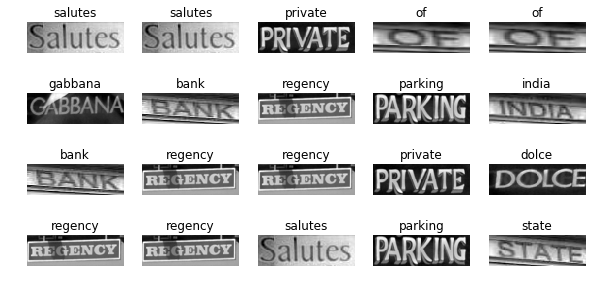

In [462]:
plot_batch_images(x_batch.reshape((len(x_batch), 32,100)), y_batch, name="benoit", predictions=None)

### Beam Search

In [471]:
def word_from_vector(word_list):
    """
    return a word string, from a word character list (eg. [4, 28, 1 ...])
    """
    try:
        return ''.join([tt.inv_vocabulary[l] for l in word_list])
    except KeyError:
        print(word)
        warnings.warn("missing char")

In [463]:
with open('tt_new.pickle', 'rb') as f:
    tt = pickle.load(f)
ngram_transformer = NgramTransform()

In [464]:
def joint_loss(word, cnn_pred, n_grams_pred):
    
    try :
        loss_cnn = np.sum([np.log(cnn_pred[i,word[i]]) for i in range(len(word))])
    except :
        loss_cnn = - np.inf
    
    loss_ngrams = 0
    word_text = word_from_vector(word)
    for i in range(len(word)):
        for n in range(1, min(5, len(word)-i+1)):
            ngrams_text = "".join([word_text[i+l] for l in range(n)])
#             print(ngrams_text)
#             print("Ngrams {}".format(ngrams_text))
            try:
                ngrams_idx = ngram_transformer.vocabulary[ngrams_text]
                loss_ngrams += np.log(n_grams_pred[ngrams_idx])
            except KeyError:
#                 loss_ngrams += -np.inf
                pass
            
    return loss_cnn + loss_ngrams

In [469]:
beam_size = 5

def beam_search(cnn_pred, n_grams_pred):
    new_candidates = []
    # candidates_ini = [np.array([i]) for i ]
    candidate_list = []

    # Char 1 
    char = 0
    for i in range(1, N_CHARS + 1):
        word = np.array([i])
        new_candidates.append(
            (joint_loss(word, cnn_pred, n_grams_pred), i))
    new_candidates.sort(reverse=True)
    candidates = new_candidates[:beam_size]
    candidate_list.append([[e[1]] for e in candidates])

    for char in range(1,SEQUENCE_LENGTH): 
    #     print(char)
        new_candidates = []
        for candidate in candidate_list[char-1]:

            for i in range(1, N_CHARS + 1):
                word = np.array(candidate + [i])
                new_candidates.append(
                    (joint_loss(word, cnn_pred, n_grams_pred), candidate + [i]))
        new_candidates.sort(reverse=True)
        candidates = new_candidates[:beam_size]
        candidate_list.append([e[1] for e in candidates])


    return tt.word_from_vector(candidate_list[22][0])

In [470]:
for i in range(len(x_batch)):
    print(beam_search(cnn_pred[i], n_grams_pred[i]), tt.word_from_matrix(cnn_pred[i]))

/home/benlet/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


privtt                  private                
paxki g                 parking                
sqluu s                 salutes                
dol                     dole                   
gxbga a                 gabbana                
re e                    renen                  
si                      siu                    
s                       sa                     
s                       61                     
s                       ma                     


#### Check on top N-grams on first word "private"

In [513]:
n_grams_pred_ = n_grams_pred[1] > 0.01
list_pred = ngram_transformer.ngram_from_matrix(n_grams_pred_)

In [514]:
ranked_values = np.sort(n_grams_pred[1])[::-1]

In [515]:
top_elements = 20
top_ngrams_idxs = np.argsort(n_grams_pred[1])[::-1][:top_elements]

In [516]:
def vecteur_de_ngrams(idx):
    out = np.zeros(10000)
    out[idx] = 1
    return out

In [517]:
print("N-grams  predictions")
for i, l in enumerate(top_ngrams_idxs): 

    print("{} \t   {:.2f}".format(ngram_transformer.ngram_from_matrix(vecteur_de_ngrams(l))[0], ranked_values[i]))

N-grams  predictions
a 	   0.08
arki 	   0.07
n 	   0.07
i 	   0.07
r 	   0.06
ing 	   0.06
rkin 	   0.05
in 	   0.05
ng 	   0.05
k 	   0.05
rki 	   0.04
g 	   0.04
ar 	   0.03
ark 	   0.03
e 	   0.03
rk 	   0.03
p 	   0.03
king 	   0.02
ki 	   0.02
kin 	   0.02


In [512]:
def word_to_list(word):
    
    return np.array([tt.tokenizer.word_index[word[i]] for i in range(len(word))])

In [491]:
word_to_list('private')

array([ 4, 15, 35, 11, 34, 23, 18])

In [447]:
joint_loss(word_to_list('priva'), cnn_pred[0], n_grams_pred[0])

-51.009159609675407

In [492]:
joint_loss(word_to_list('privt'), cnn_pred[0], n_grams_pred[0])
## Note : 'privt' a un meilleur score que priva

-45.366756677627563

In [493]:
list_all_ngrams = ngram_transformer.ngram_from_matrix(ngram_transformer.transform('private'))

In [494]:
print("N-grams in the word private and not in 10k N-grams")
print ([obj for obj in list_all if obj not in list_pred])

N-grams in the word private and not in 10k N-grams
['iv', 'ri']
